# Lab 13: Reinforcement Learning (RL)

Today we'll have a gentle introduction to reinforcement learning.
The material in today's lab comes from these references:

 - Pytorch 1.x Reinforcement Learning Cookbook (Packtpub)
 - Hands-On Reinforcement Learning for Games (Packtpub)
 - https://www.kdnuggets.com/2018/03/5-things-reinforcement-learning.html
 - Reinforcement Learning: An Introduction (Sutton et al.)
 - https://github.com/werner-duvaud/muzero-general (simulator code)


## Reinforcement learning

Reinforcement Learning (RL) is a machine learning technique that enables an agent to learn in an interactive environment by trial and error using feedback on its actions and experiences.
RL uses rewards and punishment as signals for "good" and "bad" behavior.

Generally, at each step, the agent outputs an action, which is input to the environment. The environment evolves according to its dynamics, the agent observes the new state of the environment
and (optionally) a reward, and the process continues until hopefully the agent learns what behavior maximizes its reward.

<img src="img/RL.jpg" title="Introduction" style="width: 600px;" />


## Markov decision process (MDP)

A MDP is a discrete-time stochastic control process. The MDP model is based on the idea of an environment that evolves as a Markov chain.

### Markov chain

A Markov chain is a model of the dynamics of a discrete time system that obeys the (first order) "Markov property," meaning that the state $s^{t+1}$ at time
$t+1$ is conditionally independent of the state at times $0, \ldots, t-1$ given the state at time $t$, i.e.,

$$ p(s^{t+1} \mid s^t, s^{t-1}, \ldots, s^0) = p(s^{t+1} \mid s^t). $$

Informally, we might say that the current state is all you need to know to predict the next state.

More precisely, a Markov chain is defined by a set of possible states $S={s_0, s_1, \ldots, s_n}$ and a transition matrix $T(s,s')$
containing the propbabilities of state $s$ transitioning to state $s'$. Here is a visualization of a simple Markov chain:

<img src="img/RL_markov.png" title="Markov chain" style="width: 600px;" />

You might be interested in [this Markov chain simulator](https://setosa.io/ev/markov-chains/).

Now, the dynamics of the environment in a MDP are slightly different from that of a simple Markov chain. We have to consider how the agent's
actions affect the system's dynamics. At each time step, rather than just
transitioning randomly to the next state, we add the agent's action as an external input or disturbance $a \in A$, so (assuming a small number of discrete
states and actions) the transition probabilities become a 3D tensor of size $|S|\times |A|\times |S|$
mapping each state/action pair to a probability distribution over the states.

### A simple MDP

Suppose we have three states and two actions and that the state/action transition tensor is as follows:

<img src="img/RL_statetrans.png" title="" style="width: 200px;" />

To complete our simple MDP, we need a *reward function* $R$ and a *discount factor* $\gamma$. 
Suppose $R = [ 1, 0, -1 ]$ and $\gamma = 0.5$. Let's define our MDP in Python with PyTorch tensors:


In [1]:
import torch

# State transition function

T = torch.tensor([[[0.8, 0.1, 0.1],
                   [0.1, 0.6, 0.3]],
                  [[0.7, 0.2, 0.1],
                   [0.1, 0.8, 0.1]],
                  [[0.6, 0.2, 0.2],
                   [0.1, 0.4, 0.5]]])

# Reward function

R = torch.tensor([1.,0.,-1.])

# Discount factor

gamma = 0.5

### The agent's goal

Once the MDP is defined, the agent's goal is to maximize its expected reward. If we start in state $s^0$ and perform a series
of actions $a^0, a^1, \ldots a^{T-1}$ placing us in state $s^1, s^2, \ldots s^T$, we obtain the total reward

$$ \sum_{t=0}^T \gamma^{t} R(s^t).$$

The agent's goal is to behave so as to maximize the expected total reward. To do so,
it should come up with a policy $\pi : S \times A \rightarrow \mathbb{R}$ giving a probability distribution
over actions that can be executed in each state, then when in state $s$, sample action $a$ according to that
distribution $\pi(s,\cdot)$, and repeat.

Now the agent's goal can be clearly specified as finding an optimal policy

$$ \pi^* = \textrm{argmax}_\pi \mathbb{E}_{a^t \sim \pi(s^t), s^{t} \sim T(s^{t-1},a^{t-1})}\left[ \sum_{t=0}^T \gamma^{t} R(s^t) \right]$$

Under a particular policy $\pi$, then, the *value* of state $s$ is the expected reward we obtain by following $\pi$ from state $s$:

$$ V^\pi(s) = \mathbb{E}_{a^t \sim \pi(s^t), s^{t} \sim T(s^{t-1},a^{t-1}) \mid s^0=s}\left[ R(s) + \sum_{t=1}^T \gamma^{t} R(s^t) \right]$$

The value function clearly obeys the *Bellman equations*

$$ V^\pi(s) = R(s) + \gamma \sum_{s',a'} \pi(s,a') T(s,a',s') V^\pi(s'). $$ 

### How good is a policy? Policy evaluation

To determine how good a particular policy is, we use policy evaluation.
Policy evaluation is an iterative algorithm. It starts with arbitrary values for each state
and then iteratively updates the values based on the Bellman equations until the values converge.

You can see this algorithm's pseudocode in Sutton's book on page 75.

Here we compute the value of the three states in our MDP assuming the agent always peforms the first action:

In [2]:
def policy_evaluation(policy, trans_matrix, rewards, gamma, threshold):
    n_state = policy.shape[0]
    V = torch.zeros(n_state)
    while True:
        V_temp = torch.zeros(n_state)
        for state, actions in enumerate(policy):
            for action, action_prob in enumerate(actions):
                V_temp[state] += action_prob * (rewards[state] + gamma * torch.dot(trans_matrix[state, action], V))
        max_delta = torch.max(torch.abs(V-V_temp))
        V = V_temp.clone()
        if max_delta <= threshold:
            break
    return V

threshold = 0.0001
policy_optimal = torch.tensor([[1.0, 0.0],
                               [1.0, 0.0],
                               [1.0, 0.0]])
V = policy_evaluation(policy_optimal, T, R, gamma, threshold)
print(V)

tensor([ 1.6786,  0.6260, -0.4821])


### Policy iteration

Policy iteration starts with a random policy then uses policy evaluation and the resulting values to iteratively improve the policy until an optimal policy is obtained. It is, however,
slow, due to the policy evaluation loop within the policy iteration loop.

Here's an implementation using a slightly different formulation fo the reward as a function $R(s,a,s')$ of the current state $s$, action taken $a$, and resulting state $s'$:

In [5]:
def policy_evaluation(policy, trans_matrix, rewards, gamma, threshold):
    n_state = policy.shape[0]
    V = torch.zeros(n_state)
    while True:
        V_temp = torch.zeros(n_state)
        for state in range(n_state):
            action = int(policy[state].item())
            for new_state in range(n_state):
                trans_prop = trans_matrix[state, action, new_state]
                reward = rewards[state, action, new_state]
                V_temp[state] += trans_prop * (reward + gamma * V[new_state])
        max_delta = torch.max(torch.abs(V-V_temp))
        V = V_temp.clone()
        if max_delta <= threshold:
            break
    return V

def policy_improvement(trans_matrix, rewards, gamma):
    n_state = trans_matrix.shape[0]
    n_action = trans_matrix.shape[1]
    policy = torch.zeros(n_state)

    for state in range(n_state):
        v_actions = torch.zeros(n_action)
        for action in range(n_action):
            for new_state in range(n_state):
                trans_prop = trans_matrix[state, action, new_state]
                reward = rewards[state, action, new_state]
                v_actions[action] += trans_prop * (reward + gamma * V[new_state])
        policy[state] = torch.argmax(v_actions)
    return policy

def policy_iteration(trans_matrix, rewards, gamma, threshold):
    n_state = trans_matrix.shape[0]
    n_action = trans_matrix.shape[1]
    policy = torch.randint(high=n_action, size=(n_state,)).float()
    while True:
        V = policy_evaluation(policy, trans_matrix, rewards, gamma, threshold)
        policy_improved = policy_improvement(trans_matrix, rewards, gamma)
        if torch.equal(policy_improved, policy):
            return V, policy_improved
        policy = policy_improved

# Reward R(s,a,a') example

R2 = torch.tensor([[[0.1,0.,-0.2],
                   [0.2,0.,-0.1]],
                  [[0.3,0.,-0.5],
                   [0.1,0.,-0.2]],
                  [[0.2,0.,-0.1],
                   [1.,0.,-1.]]])

V_optimal, optimal_policy = policy_iteration(T, R2, gamma, threshold)
print(V_optimal)
print(optimal_policy)

tensor([0.1352, 0.2405, 0.1829])
tensor([0., 0., 0.])


### Value iteration

Value iteration is a much more efficient way to obtain the optimial policy. It calculates the value
of each state on the assumption that the agent will deterministically select the action $a$ in state $s$
that maximizes the expected reward after that. Once this value converges, the optimal policy is just
to select the best action according to that value function:

$$ V^*(s)=R(s) + \max_a \gamma \sum_{s'} T(s,a,s') V^*(s') $$

$$ \pi^*(s) = \mathrm{argmax}_a \sum_{s'} T(s, a, s') V^*(s').$$

Instead of taking the expectation (average) of values across all actions, we pick the action that achieves the maximal policy values.
As above, we use the slightly different formulation in which the reward $R(s,a,s')$ is given based on initial state, action, and resulting state:

$$ V^*(s) = \max_a \sum_{s'} T(s,a,s') [ R(s,a,s') + \gamma V^*(s')]$$
$$ \pi^* = \mathrm{argmax}_a \sum_{s'}T(s,a,s')[R(s,a,s')+\gamma V^*(s')]$$

Here's sample code:

In [6]:
def value_iteration(trans_matrix, rewards, gamma, threshold):
    n_state = trans_matrix.shape[0]
    n_action = trans_matrix.shape[1]
    V = torch.zeros(n_state)
    while True:
        V_temp = torch.zeros(n_state)
        for state in range(n_state):
            v_actions = torch.zeros(n_action)
            for action in range(n_action):
                for new_state in range(n_state):
                    trans_prop = trans_matrix[state, action, new_state]
                    reward = rewards[state, action, new_state]
                    v_actions[action] += trans_prop * (reward + gamma * V[new_state])
            V_temp[state] = torch.max(v_actions)
        max_delta = torch.max(torch.abs(V-V_temp))
        V = V_temp.clone()
        if max_delta <= threshold:
            break
    return V

V = value_iteration(T, R2, gamma, threshold)
print(V)

tensor([0.1352, 0.2405, 0.1829])


### Exercise

Write some code now to find the optimal policy based on the values you got from value iteration above. Do you get the same result as for
policy iteration?

## OpenAI Gym

Looking at policies in matrix form is a bit difficult.

A popular simulation environment for RL is OpenAI Gym.

[OpenAI](https://openai.com) is a research company trying to develop systems exhibiting *artificial general intelligence* (AGI).
They developed Gym to support the development of RL algorithms. Gym
provides many reinforcement learning simulations and tasks. Visit [the Gym website](https://gym.openai.com) for a full list of environments.

<img src="img/RL_gym.PNG" title="Gym example" style="width: 600px;" />

### Installing Gym

Install Gym:

In [7]:
!pip install gym
# or
# !git clone https://github.com/openai/gym
# !cd gym
# pip install -a

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 1.6 MB 1.9 MB/s eta 0:00:01
     |████████████████████████████████| 1.0 MB 5.4 MB/s eta 0:00:01
     |████████████████████████████████| 2.2 MB 3.7 MB/s eta 0:00:01
  Created wheel for gym: filename=gym-0.18.0-py3-none-any.whl size=1656446 sha256=fb2ae60177e83c5aa194a0aec2ae1758fa5fd083eb1c8af709a28fc816838ccd
  Stored in directory: /tmp/pip-ephem-wheel-cache-neht8alu/wheels/d8/e7/68/a3f0f1b5831c9321d7523f6fd4e0d3f83f2705a1cbd5daaa79
Successfully built gym
  Attempting uninstall: Pillow
    Found existing installation: Pillow 8.0.1
    Uninstalling Pillow-8.0.1:
      Successfully uninstalled Pillow-8.0.1


To see visualizations easily, you should run the simulator locally, not in Jupyter.

### Atari games environment

Atari games includes video games such as Alien, Pong, and Space Race. Here is the example of using the Space Invaders game.
First, install the atari simulation environment:

In [8]:
!pip install gym[atari]

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 790 kB 1.2 MB/s eta 0:00:01
  Created wheel for atari-py: filename=atari_py-0.2.6-cp38-cp38-linux_x86_64.whl size=2812183 sha256=fe160ffca5c1ff7901860c96a1914be06d10d9076ef2d7cf8d8ac7bdf38d143a
  Stored in directory: /tmp/pip-ephem-wheel-cache-4s0peg1q/wheels/7f/5e/27/2e90b9887063d82ee2f9f8b2f8db76bb2290aa281dc40449c8
Successfully built atari-py


Then create a Space Invaders environment:

In [11]:
import gym
# create environment
env = gym.make('SpaceInvaders-v0')

# reset environments
env.reset()

array([[[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       ...,

       [[80, 89, 22],
        [80, 89, 22],
        [80, 89, 22],
        ...,
        [80, 89, 22],
        [80, 89, 22],
        [80, 89, 22]],

       [[80, 89, 22],
        [80, 89, 22],
        [80, 89, 22],
        ...,
        [80, 89, 22],
        [80, 89, 22],
        [80, 89, 22]],

       [[80, 89, 22],
        [80, 89, 22],
        [80, 89, 22],
        ...,
        [80, 89, 22],
        [80, 89, 22],
        [80, 89, 22]]], dtype=uint8)

Render the environment locally. (You cannot render in Jupyter, or let us know if you find a way!)

Locally, you should get output like this:

<img src="img/RL_SpaceInvaders.PNG" title="Space Invaders" style="width: 600px;" />

After rendering, you'll want to close the environment.

In [ ]:
# env.render()
# close the environment
# env.close()

If you cannot use Atari games due to errors occurring in Windows, you can try another simulator such as CartPole (inverted pendulum):

<img src="img/RL_CartPole.PNG" title="Cart pole" style="width: 600px;" />

In [ ]:
#import gym
# create environment
#env = gym.make('CartPole-v0')

# reset environments
#env.reset()

# render the environment
#env.render()

#env.close()

Take a look at the action space available, and try to get a sample from the action space:

In [12]:
print(env.action_space)
action = env.action_space.sample()
print(action)

Discrete(6)
2


Execute an action using `step()`.
The `step` method returns the next state after the action is taken.
 - **new_state**: The new observation
 - **reward**: The reward associated with that action in that state.
 - **is_done**: A flag to tell the game end (True).
 - **info**: extra information

In [13]:
new_state, reward, is_done, info = env.step(action)
print(is_done)
print(reward)
print(info)

False
0.0
{'ale.lives': 3}


Let's make a *while* loop with a random agent:

In [14]:
is_done = False
env.reset()
while not is_done:
    action = env.action_space.sample()
    new_state, reward, is_done, info = env.step(action)
    print(info)
    # env.render()

{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 3}
{'ale.lives': 

## Using the environments to do reinforcement learning

## Monte Carlo (MC) Method

Monte Carlo method is a model-free which have no require any prior knowledge of the environment. MC method is more scalable than MDP. MC control is used for finding the optimal policy when a policy is not given. There are 2 basically of MC control: on-policy and off-policy. On-policy method learns about the optimal policy by executing the policy and evaluating and improving it, while Off-policy method learns about the optimal policy using data generated by another policy.

## On-policy Monte Carlo control

On-policy Monte Carlo works look-a-like to policy iteration which has 2 phases: evaluation and improvement.
 - Evaluation phase: it evaluates the **action-values** (called **Q-function** $Q(s,a)$) instead of evaluates the value function.
 - Improvement phase: the policy is updated by assigning the optimal action to each stage: $\pi(s)=argmax_a Q(s,a)$

In this code below, we add **epsilon-greedy** policy which it will not exploit the best action all the time. The equations are:
 - Epsilon ($\epsilon$):

      $\pi(s,a)=\frac{\epsilon}{|A|}$  When $|A|$ is the number of all possible actions.
 - Greedy:
 
      $\pi(s,a)=1-\epsilon + \frac{\epsilon}{|A|}$

In [4]:
import torch
import gym
from collections import defaultdict

env = gym.make('Blackjack-v0')

def run_episode(env, Q, epsilon, n_action):
    state = env.reset()
    rewards = []
    actions = []
    states = []
    is_done = False
    # without epsilon-greedy
    # action = torch.randint(0, n_action, [1]).item()
    ##################################################
    while not is_done:
        # with epsilon-greedy
        probs = torch.ones(n_action) * epsilon / n_action
        best_action = torch.argmax(Q[state]).item()
        probs[best_action] += 1.0 - epsilon
        action = torch.multinomial(probs, 1).item()
        #######################################################
        actions.append(action)
        states.append(state)
        state, reward, is_done, info = env.step(action)
        rewards.append(reward)
    return states, actions, rewards

def mc_control_on_policy(env, gamma, n_episode, epsilon):
    n_action = env.action_space.n
    G_sum = defaultdict(float)
    N = defaultdict(int)
    Q = defaultdict(lambda: torch.empty(env.action_space.n))
    for episode in range(n_episode):
        states_t, actions_t, rewards_t = run_episode(env, Q, epsilon, n_action)
        return_t = 0
        G = {}
        for state_t, action_t, reward_t in zip(states_t[::-1], actions_t[::-1], rewards_t[::-1]):
            return_t = gamma * return_t + reward_t
            G[(state_t, action_t)] = return_t
            for state_action, return_t in G.items():
                state, action = state_action
                if state[0] <= 21:
                    G_sum[state_action] += return_t
                    N[state_action] += 1
                    Q[state][action] = G_sum[state_action] / N[state_action]
    policy = {}
    for state, actions in Q.items():
        policy[state] = torch.argmax(actions).item()
    return Q, policy

gamma = 1
n_episode = 500000
epsilon = 0.1
optimal_Q, optimal_policy = mc_control_on_policy(env, gamma, n_episode, epsilon)
# print(optimal_policy)
# print(optimal_Q)

def simulate_episode(env, policy):
    state = env.reset()
    is_done= False
    while not is_done:
        action = policy[state]
        state, reward, is_done, info = env.step(action)
        if is_done:
            return reward

n_episode = 100
n_win_optimal = 0
n_lose_optimal = 0
for _ in range(n_episode):
    reward = simulate_episode(env, optimal_policy)
    if reward == 1:
        n_win_optimal += 1
    elif reward == -1:
        n_lose_optimal += 1
print('after episode 100, win ', n_win_optimal, ' lose ', n_lose_optimal)

after episode 100, win  46  lose  45


## Off-policy Monte Carlo control

The Off-policy method optimizes the **target policy** ($\pi$) using data generated by another policy (**behavior policy** ($b$)).
 - Target policy: exploitation purposes, greedy with respect to its current Q-function.
 - Behavior policy: exploration purposes, generate behavior which the target policy used for learning. The behavior policy can be anything to confirm that it can explore all possibilities, then all actions and all states can be chosen with non-zero probabilities.

The weight importand for state-action pair is calculated as:

$w_t=\sum_{k=t}[\pi(a_k|s_k)/b(a_k|s_k)]$
 - $\pi(a_k|s_k)$: probabilities of taking action $a_k$ in state $s_k$
 - $b(a_k|s_k)$: probabilities under the behavior policy.

In [13]:
import torch
import gym
from collections import defaultdict

env = gym.make('Blackjack-v0')

def gen_random_policy(n_action):
    probs = torch.ones(n_action) / n_action
    def policy_function(state):
        return probs
    return policy_function

random_policy = gen_random_policy(env.action_space.n)

def run_episode(env, behavior_policy):
    state = env.reset()
    rewards = []
    actions = []
    states = []
    is_done = False
    while not is_done:
        probs = behavior_policy(state)
        action = torch.multinomial(probs, 1).item()
        actions.append(action)
        states.append(state)
        state, reward, is_done, info = env.step(action)
        rewards.append(reward)
        if is_done:
            break
    return states, actions, rewards

def mc_control_off_policy(env, gamma, n_episode, behavior_policy):
    n_action = env.action_space.n
    G_sum = defaultdict(float)
    N = defaultdict(int)
    Q = defaultdict(lambda: torch.empty(n_action))
    for episode in range(n_episode):
        W = {}
        w = 1
        states_t, actions_t, rewards_t = run_episode(env, behavior_policy)
        return_t = 0
        G = {}
        for state_t, action_t, reward_t in zip(states_t[::-1], actions_t[::-1], rewards_t[::-1]):
            return_t = gamma * return_t + reward_t
            G[(state_t, action_t)] = return_t
            w *= 1./ behavior_policy(state_t)[action_t]
            W[(state_t, action_t)] = w
            if action_t != torch.argmax(Q[state_t]).item():
                break
            
        for state_action, return_t in G.items():
            state, action = state_action
            if state[0] <= 21:
                G_sum[state_action] += return_t * W[state_action]
                N[state_action] += 1
                Q[state][action] = G_sum[state_action] / N[state_action]
    policy = {}
    for state, actions in Q.items():
        policy[state] = torch.argmax(actions).item()
    return Q, policy

gamma = 1
n_episode = 500000
optimal_Q, optimal_policy = mc_control_off_policy(env, gamma, n_episode, random_policy)
# print(optimal_policy)
# print(optimal_Q)

def simulate_episode(env, policy):
    state = env.reset()
    is_done= False
    while not is_done:
        action = policy[state]
        state, reward, is_done, info = env.step(action)
        if is_done:
            return reward

n_episode = 100
n_win_optimal = 0
n_lose_optimal = 0
for _ in range(n_episode):
    reward = simulate_episode(env, optimal_policy)
    if reward == 1:
        n_win_optimal += 1
    elif reward == -1:
        n_lose_optimal += 1
print('after episode 100, win ', n_win_optimal, ' lose ', n_lose_optimal)

after episode 100, win  41  lose  51


## Important method

As the example environments in Gym, the important methods that we need to make it in our own simulator are:
 - *reset*
 - *step*
 - *render*
 - *action_space.n* or *n_action*
 - *legal_action*

Other methods are our define.

Thus, we can understand environments of gym. Now let's try to create your own environment in Tic-tac-toe game by do look-a-like gym class.

<img src="img/RL_tictactoe.png" title="Tic tac toe" style="width: 400px;" />

## Create abstract environment

At first, create **games** folder for put the game simulators files, then create a python file named **abstract_game.py**. Put the abstract code into the file at below.

You will see the important method which used for all game simulators.

In [2]:
from abc import ABC, abstractmethod


class AbstractGame(ABC):
    """
    Inherit this class for muzero to play
    """

    @abstractmethod
    def __init__(self, seed=None):
        pass

    @abstractmethod
    def step(self, action):
        """
        Apply action to the game.
        
        Args:
            action : action of the action_space to take.

        Returns:
            The new observation, the reward and a boolean if the game has ended.
        """
        pass

    def to_play(self):
        """
        Return the current player.

        Returns:
            The current player, it should be an element of the players list in the config. 
        """
        return 0

    @abstractmethod
    def legal_actions(self):
        """
        Should return the legal actions at each turn, if it is not available, it can return
        the whole action space. At each turn, the game have to be able to handle one of returned actions.
        
        For complex game where calculating legal moves is too long, the idea is to define the legal actions
        equal to the action space but to return a negative reward if the action is illegal.

        Returns:
            An array of integers, subset of the action space.
        """
        pass

    @abstractmethod
    def reset(self):
        """
        Reset the game for a new game.
        
        Returns:
            Initial observation of the game.
        """
        pass

    def close(self):
        """
        Properly close the game.
        """
        pass

    @abstractmethod
    def render(self):
        """
        Display the game observation.
        """
        pass

    def human_to_action(self):
        """
        For multiplayer games, ask the user for a legal action
        and return the corresponding action number.

        Returns:
            An integer from the action space.
        """
        choice = input(f"Enter the action to play for the player {self.to_play()}: ")
        while int(choice) not in self.legal_actions():
            choice = input("Ilegal action. Enter another action : ")
        return int(choice)

    def expert_agent(self):
        """
        Hard coded agent that MuZero faces to assess his progress in multiplayer games.
        It doesn't influence training

        Returns:
            Action as an integer to take in the current game state
        """
        raise NotImplementedError

    def action_to_string(self, action_number):
        """
        Convert an action number to a string representing the action.

        Args:
            action_number: an integer from the action space.

        Returns:
            String representing the action.
        """
        return str(action_number)


## Let's start to tic-tac-toe

Create another file name **tictactoe.py** (in the **games\\** folder). Create a **Game** class by using the AbstractGame class as a base.

The methods which we can fill in this state are:
 - **init** method: create environment of the game such as board data, and player turn.
 - **to_play** method: return the current player.
 - **reset** method: reset board and player turn.

Afther that, we will add each method step by step.

In [7]:
import os
import numpy

from .abstract_game import AbstractGame

class Game(AbstractGame):
    """
    Game wrapper.
    """

    def __init__(self, seed=None):
        self.board = numpy.zeros((3, 3), dtype="int32")
        self.player = 0     ## player O as 0 and player X as 1

    def to_play(self):
        """
        Return the current player.

        Returns:
            The current player, it should be an element of the players list in the config. 
        """
        return self.player

    def reset(self):
        """
        Reset the game for a new game.
        
        Returns:
            Initial observation of the game.
        """
        self.board = numpy.zeros((3, 3), dtype="int32")
        self.player = 1     ## player O as 1 and player X as -1
        return self.get_observation()

    def get_observation(self):
        """
        Return current state of the game
        Returns:
            The current observation
        """
        pass
        
    def step(self, action):
        """
        Apply action to the game.
        
        Args:
            action : action of the action_space to take.

        Returns:
            The new observation, the reward and a boolean if the game has ended.
        """
        pass

    def legal_actions(self):
        """
        Should return the legal actions at each turn, if it is not available, it can return
        the whole action space. At each turn, the game have to be able to handle one of returned actions.
        
        For complex game where calculating legal moves is too long, the idea is to define the legal actions
        equal to the action space but to return a negative reward if the action is illegal.
    
        Returns:
            An array of integers, subset of the action space.
        """
        pass

    def have_winner(self):
        """
        Check that have winner.
    
        Returns:
            True if there is a winner, otherwise False
        """
        pass

    def render(self):
        """
        Display the game observation.
        """
        pass

    def human_to_action(self):
        """
        For multiplayer games, ask the user for a legal action
        and return the corresponding action number.

        Returns:
            An integer from the action space.
        """
        pass

    def expert_agent(self):
        """
        Hard coded agent that MuZero faces to assess his progress in multiplayer games.
        It doesn't influence training

        Returns:
            Action as an integer to take in the current game state
        """
        pass

    def action_to_string(self, action_number):
        """
        Convert an action number to a string representing the action.
        
        Args:
            action_number: an integer from the action space.

        Returns:
            String representing the action.
        """
        pass

## get_observation() method

The method release the current state of the game. it is up to user which want to get the game observation structure for training. As normal observation structure for 2 players, it is mostly used as 3 tensors for an observation state.
- Player1 played in the board
- Player2 played in the board
- Current player which needs to play

In [8]:
    def get_observation(self):
        board_player1 = numpy.where(self.board == 1, 1, 0)
        board_player2 = numpy.where(self.board == -1, 1, 0)
        board_to_play = numpy.full((3, 3), self.player)
        return numpy.array([board_player1, board_player2, board_to_play], dtype="int32")

## legal_actions() method

When playing the game, there are some move that players cannot play. The method needs for check where players cannot play.

In [9]:
    def legal_actions(self):
        legal = []
        for i in range(9):
            row = i // 3
            col = i % 3
            if self.board[row, col] == 0:
                legal.append(i)
        return legal

## step() method
The step method lets agent or user input the next action into the board. the method needs to update a new observation state and check whether the game is finished, and calculates the reward.

The reward for board such as tic-tac-toe, connect4, chess will have conditions like:
- The game is not finished: No reward (normally 0)
- The game is finished: Win, draw, lose (normally $[1, 0, -1]$)

Note: **have_winner** method must be used in the method, we will take a look later.

In [10]:
    def step(self, action):
        # action is a number 0-8 for declare row and column of position in the board
        row = action // 3
        col = action % 3

        # Check that the action is illegal action, unless the player should loss from illegal action.
        if not (action in self.legal_actions()):
            return self.get_observation(), -1, True

        # input the action of current player into the board
        self.board[row, col] = self.player

        # Check that the game is finished in 2 condition: have a winner, or no any moves left
        have_win = self.have_winner()
        done = have_win or len(self.legal_actions()) == 0

        # If have the winner, the current player should be a winner.
        reward = 1 if have_win else 0

        # change current player
        self.player *= -1

        return self.get_observation(), reward, done

## have_winner() method

This method is used for check the game has winner. In tic-tac-toe, it can win when there are same 3 marks in the same horizontal or vertical, or diagonal.

In [11]:
    def have_winner(self):
        # Horizontal and vertical checks
        for i in range(3):
            if (self.board[i, :] == self.player * numpy.ones(3, dtype="int32")).all():
                return True
            if (self.board[:, i] == self.player * numpy.ones(3, dtype="int32")).all():
                return True

        # Diagonal checks
        if (
            self.board[0, 0] == self.player
            and self.board[1, 1] == self.player
            and self.board[2, 2] == self.player
        ):
            return True
        if (
            self.board[2, 0] == self.player
            and self.board[1, 1] == self.player
            and self.board[0, 2] == self.player
        ):
            return True

        return False

## Prototype is done

Ok, now you have your prototype simulator which the code should be look liked this.

In [ ]:
class Game(AbstractGame):
    """
    Game wrapper.
    """

    def __init__(self, seed=None):
        self.board = numpy.zeros((3, 3), dtype="int32")
        self.player = 0     ## player O as 0 and player X as 1

    def to_play(self):
        """
        Return the current player.

        Returns:
            The current player, it should be an element of the players list in the config. 
        """
        return self.player

    def reset(self):
        """
        Reset the game for a new game.
        
        Returns:
            Initial observation of the game.
        """
        self.board = numpy.zeros((3, 3), dtype="int32")
        self.player = 1     ## player O as 1 and player X as -1
        return self.get_observation()

    def get_observation(self):
        """
        Return current state of the game
        Returns:
            The current observation
        """
        board_player1 = numpy.where(self.board == 1, 1, 0)
        board_player2 = numpy.where(self.board == -1, 1, 0)
        board_to_play = numpy.full((3, 3), self.player)
        return numpy.array([board_player1, board_player2, board_to_play], dtype="int32")
        
    def step(self, action):
        """
        Apply action to the game.
        
        Args:
            action : action of the action_space to take.

        Returns:
            The new observation, the reward and a boolean if the game has ended.
        """
        # action is a number 0-8 for declare row and column of position in the board
        row = action // 3
        col = action % 3

        # Check that the action is illegal action, unless the player should loss from illegal action.
        if not (action in self.legal_actions()):
            return self.get_observation(), -1, True

        # input the action of current player into the board
        self.board[row, col] = self.player

        # Check that the game is finished in 2 condition: have a winner, or no any moves left
        have_win = self.have_winner()
        done = have_win or len(self.legal_actions()) == 0

        # If have the winner, the current player should be a winner.
        reward = 1 if have_win else 0

        # change current player
        self.player *= -1

        return self.get_observation(), reward, done

    def legal_actions(self):
        """
        Should return the legal actions at each turn, if it is not available, it can return
        the whole action space. At each turn, the game have to be able to handle one of returned actions.
        
        For complex game where calculating legal moves is too long, the idea is to define the legal actions
        equal to the action space but to return a negative reward if the action is illegal.
    
        Returns:
            An array of integers, subset of the action space.
        """
        legal = []
        for i in range(9):
            row = i // 3
            col = i % 3
            if self.board[row, col] == 0:
                legal.append(i)
        return legal

    def have_winner(self):
        """
        Check that have winner.
    
        Returns:
            True if there is a winner, otherwise False
        """
        # Horizontal and vertical checks
        for i in range(3):
            if (self.board[i, :] == self.player * numpy.ones(3, dtype="int32")).all():
                return True
            if (self.board[:, i] == self.player * numpy.ones(3, dtype="int32")).all():
                return True

        # Diagonal checks
        if (
            self.board[0, 0] == self.player
            and self.board[1, 1] == self.player
            and self.board[2, 2] == self.player
        ):
            return True
        if (
            self.board[2, 0] == self.player
            and self.board[1, 1] == self.player
            and self.board[0, 2] == self.player
        ):
            return True

        return False

    def render(self):
        """
        Display the game observation.
        """
        pass

    def human_to_action(self):
        """
        For multiplayer games, ask the user for a legal action
        and return the corresponding action number.

        Returns:
            An integer from the action space.
        """
        pass

    def expert_agent(self):
        """
        Hard coded agent that MuZero faces to assess his progress in multiplayer games.
        It doesn't influence training

        Returns:
            Action as an integer to take in the current game state
        """
        pass

    def action_to_string(self, action_number):
        """
        Convert an action number to a string representing the action.
        
        Args:
            action_number: an integer from the action space.

        Returns:
            String representing the action.
        """
        pass

Let's try to run your simulator.

In [1]:
import importlib

game_name = 'tictactoe'
game_module = importlib.import_module("games." + game_name)
env = game_module.Game()

env.reset()

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]]], dtype=int32)

In [2]:
env.reset()

next_state, reward, done = env.step(4)
print(next_state, 'reward', reward, 'is_done:', done)

next_state, reward, done = env.step(5)
print(next_state, 'reward', reward, 'is_done:', done)

next_state, reward, done = env.step(1)
print(next_state, 'reward', reward, 'is_done:', done)

next_state, reward, done = env.step(6)
print(next_state, 'reward', reward, 'is_done:', done)

next_state, reward, done = env.step(7)
print(next_state, 'reward', reward, 'is_done:', done)

[[[ 0  0  0]
  [ 0  1  0]
  [ 0  0  0]]

 [[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]

 [[-1 -1 -1]
  [-1 -1 -1]
  [-1 -1 -1]]] reward 0 is_done: False
[[[0 0 0]
  [0 1 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 1]
  [0 0 0]]

 [[1 1 1]
  [1 1 1]
  [1 1 1]]] reward 0 is_done: False
[[[ 0  1  0]
  [ 0  1  0]
  [ 0  0  0]]

 [[ 0  0  0]
  [ 0  0  1]
  [ 0  0  0]]

 [[-1 -1 -1]
  [-1 -1 -1]
  [-1 -1 -1]]] reward 0 is_done: False
[[[0 1 0]
  [0 1 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 1]
  [1 0 0]]

 [[1 1 1]
  [1 1 1]
  [1 1 1]]] reward 0 is_done: False
[[[ 0  1  0]
  [ 0  1  0]
  [ 0  1  0]]

 [[ 0  0  0]
  [ 0  0  1]
  [ 1  0  0]]

 [[-1 -1 -1]
  [-1 -1 -1]
  [-1 -1 -1]]] reward 1 is_done: True


## Do more fancier: render() method

Add viewer more beautiful and clearly. Input the method into **render**

In [3]:
    def render(self):
        for i in range(5):
            row = int(i / 2)
            str = ""
            for j in range(11):
                col = int(j / 4)
                if i == row * 2 + 1 and j == col * 4 + 3:
                    str += "+"
                elif i == row * 2 and j == col * 4 + 1:
                    if self.board[row,col] == 1:
                        str += "O"
                    elif self.board[row,col] == -1:
                        str += "X"
                    else:
                        str += " "
                elif i == row * 2 + 1:
                    str += "-"
                elif j == col * 4 + 3:
                    str += "|"
                
                else:
                    str += " "
            print(str)

In [4]:
env.render()

   | O |   
---+---+---
   | O | X 
---+---+---
 X | O |   


## Fill other methods

 - action_to_string
 - human_to_action

In [5]:
    def action_to_string(self, action_number):
        row = action_number // 3 + 1
        col = action_number % 3 + 1
        return f"Play row {row}, column {col}"

    def human_to_action(self):
        while True:
            try:
                row = int(
                    input(
                        f"Enter the row (1, 2 or 3) to play for the player {self.to_play()}: "
                    )
                )
                col = int(
                    input(
                        f"Enter the column (1, 2 or 3) to play for the player {self.to_play()}: "
                    )
                )
                choice = (row - 1) * 3 + (col - 1)
                if (
                    choice in self.legal_actions()
                    and 1 <= row
                    and 1 <= col
                    and row <= 3
                    and col <= 3
                ):
                    break
            except:
                pass
            print("Wrong input, try again")
        return choice

## Special method for training: expert_action

This method is used for training or measuring how strong of your agent.

In [ ]:
    def expert_action(self):
        board = self.board
        action = numpy.random.choice(self.legal_actions())
        # Horizontal and vertical checks
        for i in range(3):
            if abs(sum(board[i, :])) == 2:
                ind = numpy.where(board[i, :] == 0)[0][0]
                action = numpy.ravel_multi_index((numpy.array([i]), numpy.array([ind])), (3, 3))[0]
                if self.player * sum(board[i, :]) > 0:
                    return action

            if abs(sum(board[:, i])) == 2:
                ind = numpy.where(board[:, i] == 0)[0][0]
                action = numpy.ravel_multi_index((numpy.array([ind]), numpy.array([i])), (3, 3))[0]
                if self.player * sum(board[:, i]) > 0:
                    return action

        # Diagonal checks
        diag = board.diagonal()
        anti_diag = numpy.fliplr(board).diagonal()
        if abs(sum(diag)) == 2:
            ind = numpy.where(diag == 0)[0][0]
            action = numpy.ravel_multi_index((numpy.array([ind]), numpy.array([ind])), (3, 3))[0]
            if self.player * sum(diag) > 0:
                return action

        if abs(sum(anti_diag)) == 2:
            ind = numpy.where(anti_diag == 0)[0][0]
            action = numpy.ravel_multi_index((numpy.array([ind]), numpy.array([2 - ind])), (3, 3))[0]
            if self.player * sum(anti_diag) > 0:
                return action

        return action

## Try your simulator

Make sure that your simulator does not have any problems.

## Temporal Difference (TD)

Temporal Difference (TD) learning is a model-free learning algorithm like MC learning. In MC learning, Q-function is called and updated at the end of the entire episode, but TD learning update Q-function every step of an episode. One of the TD learning algorithm is Q-learning

## Q-Learning

Q-leaning is an off-policy learning algorithm. The Q-function is based on the equation:

$Q(s,a)=Q(s,a)+\alpha(r+\gamma\max_{a'}Q(s',a')-Q(s,a))$

Where
 - $\alpha$: learning rate
 - $\gamma$: discount factor
 - $\max_{a'}Q(s',a')$: greedy behavior policy, the highest Q-value among those in state $s'$ is selected to generate learning data.

We know from class that Q-learning finds the optimal greedy policy while running an epsilon-greedy policy. 

In [50]:
import importlib
from collections import defaultdict
import torch
import numpy

game_name = 'tictactoe'
game_module = importlib.import_module("games." + game_name)
env = game_module.Game()

env.reset()

# defining epsilon-greedy policy
def gen_epsilon_greedy_policy(n_action, epsilon):
    def policy_function(state, Q, available_actions):
        probs = torch.ones(n_action) * epsilon / n_action
        # print(probs)
        # print(state)
        # print(Q[state])
        best_action = torch.argmax(Q[state]).item()
        if not(best_action in available_actions):
            best_action = -1
            Q_max = -800000000
            for i in range(n_action):
                if i in available_actions and Q_max < Q[state][i]:
                    Q_max = Q[state][i]
                    best_action = i
        probs[best_action] += 1.0 - epsilon
        action = torch.multinomial(probs, 1).item()
        return action
    return policy_function

def q_learning(env, gamma, n_episode, alpha, player):
    """
    Obtain the optimal policy with off-policy Q-learning method
    @param env: OpenAI Gym environment
    @param gamma: discount factor
    @param n_episode: number of episodes
    @return: the optimal Q-function, and the optimal policy
    """
    n_action = 9
    Q = defaultdict(lambda: torch.zeros(n_action))
    for episode in range(n_episode):
        if episode % 10000 == 9999:
            print("episode: ", episode + 1)
        state = env.reset()
        state = hash(tuple(state.reshape(-1)))

        is_done = False
        while not is_done:
            if env.to_play() == player:
                available_action = env.legal_actions()
                action = epsilon_greedy_policy(state, Q, available_action)
                next_state, reward, is_done = env.step(action)
                next_state = hash(tuple(next_state.reshape(-1)))
                td_delta = reward + gamma * torch.max(Q[next_state]) - Q[state][action]
                Q[state][action] += alpha * td_delta
            else:
                action = env.expert_agent()
                next_state, reward, is_done = env.step(action)
                next_state = hash(tuple(next_state.reshape(-1)))

                if is_done:
                    reward = -reward
                    td_delta = reward + gamma * torch.max(Q[next_state]) - Q[state][action]
                    Q[state][action] += alpha * td_delta

            length_episode[episode] += 1
            total_reward_episode[episode] += reward

            if is_done:
                break
            state = next_state

    policy = {}
    for state, actions in Q.items():
        policy[state] = torch.argmax(actions).item()
    return Q, policy

gamma = 1

n_episode = 1000000

alpha = 0.4

epsilon = 0.1

available_action = env.legal_actions()
epsilon_greedy_policy = gen_epsilon_greedy_policy(9, epsilon)

length_episode = [0] * n_episode
total_reward_episode = [0] * n_episode

# agent play first
optimal_Q, optimal_policy = q_learning(env, gamma, n_episode, alpha, 1)


print('The optimal policy:\n', optimal_policy)

5: 0, -8921562862055878748: 0, 5804471335317639714: 6, 1222802750924923823: 0, 8748956428649517688: 0, 2909964738678234170: 0, -6491943597298662998: 0, 3447602624896303656: 0, -3304069188338600697: 0, -1478061838276642523: 0, -8259897177948066666: 0, -6139116141089208671: 0, -5324109887964636169: 0, 1271978875132078937: 0, 5677256947168970719: 3, 8047552283934953556: 0, 5617795650212269352: 0, 3630845068636650362: 0, 3704031541910399844: 0, -1295474922522984264: 0, 15403383379866475: 0, 4028274238675309913: 0, 3075498732548716036: 0, 396903780980753027: 0, -2903387146842176953: 0, -6080136958132622774: 0, -4026211331039043401: 0, 7814348627122961182: 0, 4143031009545620326: 0, -13033546906471243: 0, 6560102334827197799: 0, 8260039137891933802: 0, -4660198133650040: 0, -4666419504314519616: 0, -372358769423872095: 0, -5194136811097380033: 0, -668739533188762136: 0, 5386951221386053076: 0, 9159537521389301381: 0, -4779982424788258116: 3, -7263158734089982026: 0, -4026227037530479219: 0, 

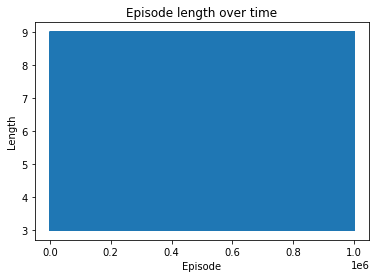

[-1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, 0, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, -1, -1, -1, -1, -1, -1, -1, 1, 0, -1, -1, 1, 1, -1, -1, -1, -1, -1]


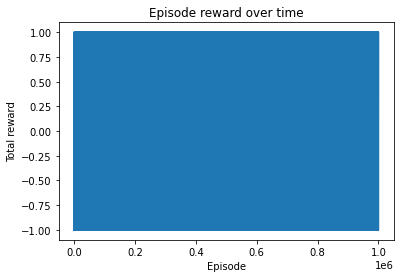

In [56]:
import matplotlib.pyplot as plt

plt.plot(length_episode)
plt.title('Episode length over time')
plt.xlabel('Episode')
plt.ylabel('Length')
plt.show()


plt.plot(total_reward_episode)
print(total_reward_episode[-100:])
plt.title('Episode reward over time')
plt.xlabel('Episode')
plt.ylabel('Total reward')
plt.show()

In [53]:
state = env.reset()
state = hash(tuple(state.reshape(-1)))

player = 1
is_done = False
while not is_done:
    if env.to_play() == player:
        available_action = env.legal_actions()
        print("available action:",available_action)
        action = epsilon_greedy_policy(state, optimal_Q, available_action)
        next_state, reward, is_done = env.step(action)
        next_state = hash(tuple(next_state.reshape(-1)))
        print("RL agent")
        print(env.action_to_string(action))
    else:
        action = env.expert_agent()
        next_state, reward, is_done = env.step(action)
        next_state = hash(tuple(next_state.reshape(-1)))
        print("Expert agent")
        print(env.action_to_string(action))

    state = next_state
    env.render()

available action: [0, 1, 2, 3, 4, 5, 6, 7, 8]
RL agent
Play row 1, column 1
 O |   |   
---+---+---
   |   |   
---+---+---
   |   |   
Expert agent
Play row 2, column 1
 O |   |   
---+---+---
 X |   |   
---+---+---
   |   |   
available action: [1, 2, 4, 5, 6, 7, 8]
RL agent
Play row 1, column 2
 O | O |   
---+---+---
 X |   |   
---+---+---
   |   |   
Expert agent
Play row 1, column 3
 O | O | X 
---+---+---
 X |   |   
---+---+---
   |   |   
available action: [4, 5, 6, 7, 8]
RL agent
Play row 2, column 2
 O | O | X 
---+---+---
 X | O |   
---+---+---
   |   |   
Expert agent
Play row 3, column 3
 O | O | X 
---+---+---
 X | O |   
---+---+---
   |   | X 
available action: [5, 6, 7]
RL agent
Play row 3, column 2
 O | O | X 
---+---+---
 X | O |   
---+---+---
   | O | X 


## SARSA

In contrast, Q-learning is an off-policy TD learning algorithm, SARSA is an **on-policy TD learning** algorithm.

SARSA (full name: State-Action-Reward-State-Action) looked similar to Q-learning which forcuses on state-action value. The Q-function is:

$Q(s,a)=Q(s,a)+\alpha(r+\gamma Q(s',a')-Q(s,a))$

In stead of using behavior-greedy policy $\max_{a'}Q(s',a')$ like Q-learning, SARSA just select the next action $a'$ following an epsilon-greedy policy to update the Q-value.
However, the action $a'$ must use in the next step (no matter what).

It may not good for 2 players games (What happen if our opponent not play in the same position?)

## SARSA code example

    def gen_epsilon_greedy_policy(n_action, epsilon):
        def policy_function(state, Q):
            probs = torch.ones(n_action) * epsilon / n_action
            best_action = torch.argmax(Q[state]).item()
            probs[best_action] += 1.0 - epsilon
            action = torch.multinomial(probs, 1).item()
            return action
        return policy_function

    def sarsa(env, gamma, n_episode, alpha):
        """
        Obtain the optimal policy with on-policy SARSA algorithm
        @param env: OpenAI Gym environment
        @param gamma: discount factor
        @param n_episode: number of episodes
        @return: the optimal Q-function, and the optimal policy
        """
        n_action = env.action_space.n
        Q = defaultdict(lambda: torch.zeros(n_action))
        for episode in range(n_episode):
            state = env.reset()
            is_done = False
            action = epsilon_greedy_policy(state, Q)
            while not is_done:
                next_state, reward, is_done, info = env.step(action)
                next_action = epsilon_greedy_policy(next_state, Q)
                td_delta = reward + gamma * Q[next_state][next_action] - Q[state][action]
                Q[state][action] += alpha * td_delta
                length_episode[episode] += 1
                total_reward_episode[episode] += reward
                if is_done:
                    break
                state = next_state
                action = next_action
        policy = {}
        for state, actions in Q.items():
            policy[state] = torch.argmax(actions).item()
        return Q, policy

## Experience replay

To improve the performance of Q-learning, we use **experience replay**.

**Experience replay** means we store the agent's experiences during an episode instead of running Q-learning. The learning phase with experience replay becomes two phases: gaining experience and updating models based on the experience obtained after an episode finishes. Specifically, the experience (also called the buffer, or memory) includes the past state, the action taken, the reward received, and the next state for individual steps in an episode.

In the learning phase, a certain number of data points are randomly sampled from the experience and are used to train the learning models. Experience replay can stabilize training by providing a set of samples with low correlation, which, as a result, increases learning efficiency.

## Homework

- Bugs fix, make save optimal Q
- Try to make experience replay
- Do a game simulator themselves such as Connect4.
- Apply RL such as MC control, Q-Learning in the simulator.
- Try to make DQN ;)